In [20]:
!pip install keras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.12.0 which is incompatible.


In [55]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
df = pd.read_csv('SPAM text message 20170820 - Data.csv',delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.index = range(5572)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

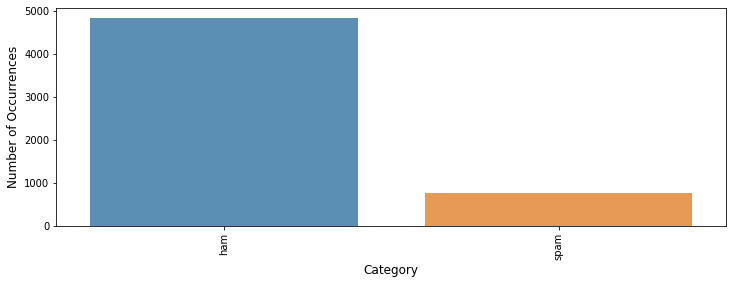

In [7]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index,y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [8]:
def print_message(index):
    example = df[df.index == index][['Message', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

URGENT! You have won a 1 week FREE membership in our Â£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Message: spam


In [9]:
print_message(0)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Message: ham


Preprocessing of Text The function to lowercase text, remove punctuation and symbols from words, and more is defined below.


In [10]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

<ipython-input-10-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [13]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
from keras.utils import pad_sequences


In [26]:
df['Message'] = df['Message'].apply(cleanText)
train,test = train_test_split(df, test_size=0.000001, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

<ipython-input-10-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


Found 5572 unique tokens.


In [27]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [28]:
train_tagged.values

array([TaggedDocument(words=['and', 'also', 'i', "'ve", 'sorta', 'blown', 'him', 'off', 'a', 'couple', 'times', 'recently', 'so', 'id', 'rather', 'not', 'tet', 'him', 'out', 'of', 'the', 'blue', 'looking', 'for', 'weed'], tags=['ham']),
       TaggedDocument(words=['mmm', 'thats', 'better', 'now', 'i', 'got', 'a', 'roast', 'down', 'me', '!', 'iâ\x92d', 'b', 'better', 'if', 'i', 'had', 'a', 'few', 'drinks', 'down', 'me', '2', '!', 'good', 'indian', '?'], tags=['ham']),
       TaggedDocument(words=['mm', 'have', 'some', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok'], tags=['ham']),
       ...,
       TaggedDocument(words=['prabha', '..', 'i', "'m", 'soryda', '..', 'realy', '..', 'frm', 'heart', 'i', "'m", 'sory'], tags=['ham']),
       TaggedDocument(words=['nt', 'joking', 'seriously', 'i', 'told'], tags=['ham']),
       TaggedDocument(words=['did', 'he', 'just', 'say', 'somebody', 'is', 'named', 'tampa'], tags=['ham'])],
      dtype=object)

In [44]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 5571/5571 [00:00<00:00, 1031586.58it/s]


In [32]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 5571/5571 [00:00<00:00, 1394263.83it/s]


CPU times: user 13.3 s, sys: 69.4 ms, total: 13.3 s
Wall time: 14.7 s


In [33]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [46]:
len(d2v_model.wv.key_to_index)

9361

In [49]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index)+ 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

Measuring distance between two vectors (related to cosine similarity)

In [50]:
d2v_model.wv.most_similar(positive=['urgent'], topn=10)

[('dictionary', 0.7548812627792358),
 ('gv', 0.7385099530220032),
 ('09090900040', 0.737850546836853),
 ('end', 0.7174364924430847),
 ('s3y', 0.697420060634613),
 ('praying.will', 0.6842852830886841),
 ('geoenvironmental', 0.6712071895599365),
 ('fortune', 0.6684834957122803),
 ('close', 0.6667903065681458),
 ('spjanuary', 0.6650495529174805)]

In [51]:
d2v_model.wv.most_similar(positive=['cherish'], topn=10)

[('plane', 0.8153259754180908),
 ('dl', 0.7004007697105408),
 ('sharing', 0.6975506544113159),
 ('passes', 0.6860136985778809),
 ('0721072', 0.6782993674278259),
 ('loahatchee', 0.6699919700622559),
 ('trauma', 0.6698644757270813),
 ('bend', 0.6638799905776978),
 ('cr', 0.6539549827575684),
 ('09061701851.', 0.6466493010520935)]

Create the LSTM Model

In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
model = Sequential()
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 20)            187240    
                                                                 
 lstm_3 (LSTM)               (None, 50)                14200     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 201,542
Trainable params: 201,542
Non-trainable params: 0
_________________________________________________________________


In [58]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Dropout,Activation
model1 = Sequential()
model1.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))
def split_input(sequence):
     return sequence[:-1],tf.reshape(sequence[1:], (-1,1))
model1.add(LSTM(50,return_sequences=False))
model1.add(Dense(2,activation="softmax"))
model1.add(Activation('relu'))
model1.add(Dense(256,name='FC1'))
model1.add(Dropout(0.5))
model1.summary()
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 20)            187240    
                                                                 
 lstm_5 (LSTM)               (None, 50)                14200     
                                                                 
 dense_5 (Dense)             (None, 2)                 102       
                                                                 
 activation_2 (Activation)   (None, 2)                 0         
                                                                 
 FC1 (Dense)                 (None, 256)               768       
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
Total params: 202,310
Trainable params: 202,310
Non-tr

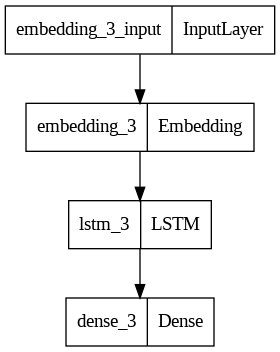

In [59]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

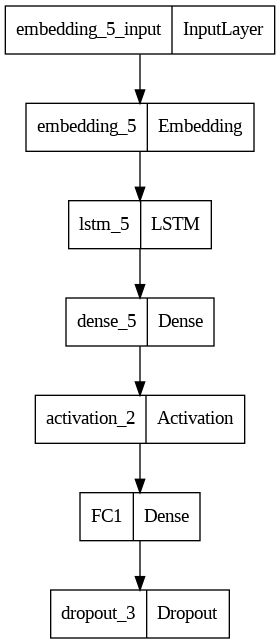

In [60]:
from keras.utils import plot_model
plot_model(model1, to_file='model1.png')

In [61]:
Y = pd.get_dummies(df['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4736, 50) (4736, 2)
(836, 50) (836, 2)


In [63]:
import logging
logging.getLogger('tensorflow').disabled = True

In [64]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =10, batch_size=batch_size, verbose = 2)

Epoch 1/10
148/148 - 5s - loss: 0.0011 - acc: 0.9998 - 5s/epoch - 32ms/step
Epoch 2/10
148/148 - 3s - loss: 8.4984e-04 - acc: 1.0000 - 3s/epoch - 23ms/step
Epoch 3/10
148/148 - 3s - loss: 6.3511e-04 - acc: 1.0000 - 3s/epoch - 23ms/step
Epoch 4/10
148/148 - 3s - loss: 5.1093e-04 - acc: 1.0000 - 3s/epoch - 23ms/step
Epoch 5/10
148/148 - 5s - loss: 3.9178e-04 - acc: 1.0000 - 5s/epoch - 32ms/step
Epoch 6/10
148/148 - 3s - loss: 3.5708e-04 - acc: 1.0000 - 3s/epoch - 23ms/step
Epoch 7/10
148/148 - 3s - loss: 2.7803e-04 - acc: 1.0000 - 3s/epoch - 23ms/step
Epoch 8/10
148/148 - 4s - loss: 2.3615e-04 - acc: 1.0000 - 4s/epoch - 29ms/step
Epoch 9/10
148/148 - 4s - loss: 1.9751e-04 - acc: 1.0000 - 4s/epoch - 26ms/step
Epoch 10/10
148/148 - 3s - loss: 1.6545e-04 - acc: 1.0000 - 3s/epoch - 23ms/step


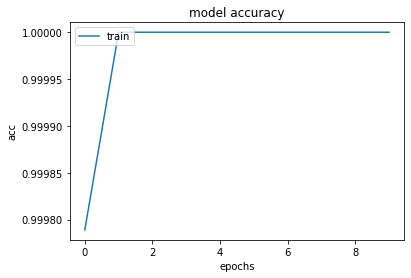

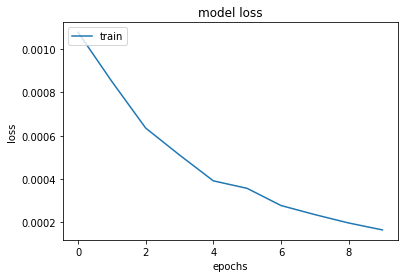

<Figure size 432x288 with 0 Axes>

In [65]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [67]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=2)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

148/148 - 1s - loss: 1.5123e-04 - acc: 1.0000 - 1s/epoch - 10ms/step
27/27 - 0s - loss: 0.0607 - acc: 0.9928 - 265ms/epoch - 10ms/step
Train accuracy: 1.0
Test accuracy: 0.9928229451179504


In [122]:
from keras.utils import to_categorical
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = model.predict(X_test, verbose=2)
print(yhat_classes)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

[[9.9999994e-01 6.7824257e-12]
 [9.9999994e-01 1.5362477e-10]
 [9.9999994e-01 9.0528939e-12]
 ...
 [1.0000000e+00 1.2621942e-10]
 [1.0000000e+00 2.8708675e-09]
 [1.0000000e+00 3.5669523e-11]]
20/20 - 0s - 452ms/epoch - 23ms/step
[[9.9999994e-01 6.7824257e-12]
 [9.9999994e-01 1.5362477e-10]
 [9.9999994e-01 9.0528939e-12]
 ...
 [1.0000000e+00 1.2621942e-10]
 [1.0000000e+00 2.8708675e-09]
 [1.0000000e+00 3.5669523e-11]]


In [123]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

In [126]:
print(yhat_classes.ndim)
yhat_classes.mean(axis=1)

2


array([0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.5       , 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.5       , 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999994, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999994, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.49999997,
       0.49999997, 0.49999997, 0.49999997, 0.49999997, 0.5    

In [131]:
yhat_classes=np.argmax(Y_test,axis = 1)
yhat_classes
print(rounded_labels.shape)
print(yhat_classes.shape)


(636,)
(636,)


In [132]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[555,   0],
       [  0,  81]])

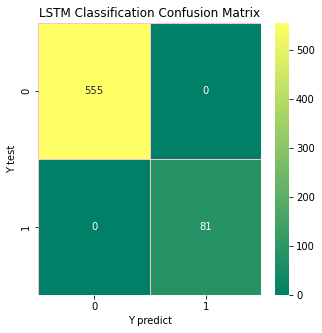

In [135]:
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='pink', fmt='g', ax=ax, cmap="summer")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [99]:
validation_size = 200

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

20/20 [==============================] - 0s 10ms/step - loss: 0.0908 - acc: 0.9858
score: 0.09
acc: 0.99


In [100]:
model.save('Mymodel.h5')

In [101]:
message = ['Congratulations! you have won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 36ms/step
[[9.8791624e-08 9.9999988e-01]] spam
